# Modeling

## Plan
1. Base accuracy: random guessing.
2. Feature engineering from exploratory analysis.
3. Apply a decision tree / parameter tuning. 
4. Evaluate models: learning curve, feature importance, confusion matrix.
5. Advanced models: random forest, boosting tree, neural network.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
% matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

# 1. Accuracy for random guessing

In [3]:
survived_cnt = df.Survived.value_counts()
print('Overall non-survival rate = %.1f%%' %(survived_cnt[0]/(survived_cnt[0]+survived_cnt[1])*100))

Overall non-survival rate = 61.6%


# 2. Preprocess: feature engineering

In [4]:
from sklearn.preprocessing import LabelEncoder

def getTitle(s):
    first,last = s.split(',')
    
    last = last.strip()
    title = ''
    if last.find('.') != -1:
        title = last.split('.')[0]
        
    if title not in ['Mr', 'Mrs', 'Miss', 'Master']:
        return 'Else'
    return title

def preprocess(df):
    X = df.copy()
    
    X['title'] = X.Name.map(getTitle);

    X['familySize'] = X.SibSp + X.Parch
    X['familySize'] = X['familySize'].map(lambda x: x+1)
    
    X.Age.fillna(1000, inplace=True)
    X['ageCat'] = pd.cut(X['Age'], bins=[0,18,30,60, 100, 2000])
    
    X['cabin'] = 0
    X.loc[X.Cabin.notnull(), 'cabin'] = 1
    
    X.Embarked.fillna('C', inplace=True)
    
    X['Sex'] = LabelEncoder().fit_transform(X['Sex'].values)
    X['title'] = LabelEncoder().fit_transform(X['title'].values)
    X['ageCat'] = LabelEncoder().fit_transform(X['ageCat'].values)
    X['Embarked'] = LabelEncoder().fit_transform(X['Embarked'].values)
    
    X = X[['Pclass','Sex', 'title', 'familySize', 'Fare', 'Age', 'cabin', 'Embarked']]
    
    return X

In [5]:
X = preprocess(df)
y = df['Survived']

In [6]:
X.head()

,Pclass,Sex,title,familySize,Fare,Age,cabin,Embarked
0,3,1,3,2,7.2500,22.0,0,2
1,1,0,4,2,71.2833,38.0,1,0
2,3,0,2,1,7.9250,26.0,0,2
3,1,0,4,2,53.1000,35.0,1,2
4,3,1,3,1,8.0500,35.0,0,2


# 3. Modeling with a decision tree 

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import time
from sklearn import tree
import pydotplus 
from IPython.display import Image  

def printFeatureImportance(clf, X,y):
    print('\n feature importance:')
    clf.fit(X, y)
    features = X.columns
    importances = clf.feature_importances_
    arg_sort = np.argsort(importances)[::-1]
    n = min(len(features), 10)
    for i in range(n):
        idx = arg_sort[i]
        print('%2d. %-*s %.2f %%' %(i+1,15, features[idx],importances[idx]*100))
        
def printTreeNode(clf, feature_names=None, class_names=None):
    dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=feature_names,  
                                class_names=class_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return graph.create_png()
        
def fitTree(X,y, estimator=DecisionTreeClassifier, param_grid=None, cv=5):
    t1 = time.time()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    
    clf = estimator()
     
    if param_grid:
        gs = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=cv)
        gs = gs.fit(X_train, y_train)
        clf = gs.best_estimator_
        print('best param: ' + str(gs.best_params_))
        print('grid search time: %.2f sec.' %(time.time()-t1))
    
    train_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv)
    test_scores = cross_val_score(estimator=clf, X=X_test, y=y_test, cv=cv)
    
    print('train mean accuracy: %.2f %% (std=%.2f %%)' 
              %(np.mean(train_scores)*100, np.std(train_scores)*100))
    print('test mean accuracy: %.2f %% (std=%.2f %%)' 
              %(np.mean(test_scores)*100, np.std(test_scores)*100))
    
    printFeatureImportance(clf,X,y)
    print('\n total time: %.2f sec.' %(time.time()-t1))
    return clf

In [8]:
from sklearn.model_selection import learning_curve
def drawLearningCurve(clf, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X, y=y, cv=5, train_sizes=np.linspace(0.1,1,10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    plt.plot(train_sizes, train_mean, 'b-')

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, test_mean, 'r-')

    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.1, color='red')

In [9]:
clf_dt = fitTree(X,y)
clf_dt

train mean accuracy: 76.24 % (std=2.28 %)
test mean accuracy: 74.62 % (std=3.51 %)

 feature importance:
 1. Sex             30.53 %
 2. Age             24.47 %
 3. Fare            20.97 %
 4. Pclass          8.81 %
 5. familySize      6.99 %
 6. cabin           4.03 %
 7. title           2.29 %
 8. Embarked        1.91 %

 total time: 0.06 sec.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

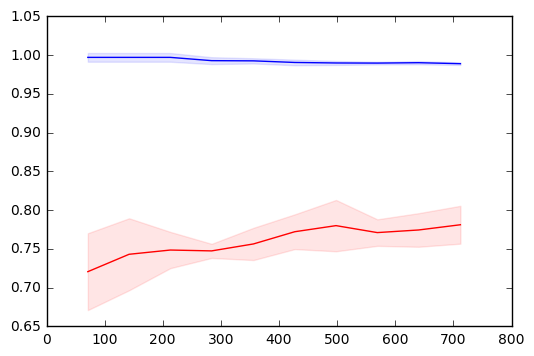

In [10]:
drawLearningCurve(clf_dt, X, y)

- We see that the model is suffering from overfitting.

## Parameter tuning

- We use GridSearchCV for parameter tuning, in this case 'max_depth' of a tree. 
- We print feature importance (relative contribution to 'gini index' improvement).
- We visualize a decision tree.

In [11]:
param_grid = [ {'max_depth':[3,4,5]} ]

clf_dt_gs = fitTree(X,y,param_grid=param_grid)
clf_dt_gs

best param: {'max_depth': 3}
grid search time: 0.11 sec.
train mean accuracy: 79.62 % (std=1.38 %)
test mean accuracy: 80.98 % (std=1.18 %)

 feature importance:
 1. Sex             64.22 %
 2. Pclass          16.08 %
 3. cabin           7.28 %
 4. Age             7.24 %
 5. familySize      5.19 %
 6. Embarked        0.00 %
 7. Fare            0.00 %
 8. title           0.00 %

 total time: 0.13 sec.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

# Visualize decision rules

best param: {'max_depth': 2}
grid search time: 0.03 sec.
train mean accuracy: 79.28 % (std=2.63 %)
test mean accuracy: 82.07 % (std=4.62 %)

 feature importance:
 1. Sex             73.33 %
 2. Pclass          18.36 %
 3. cabin           8.31 %
 4. Embarked        0.00 %
 5. Age             0.00 %
 6. Fare            0.00 %
 7. familySize      0.00 %
 8. title           0.00 %

 total time: 0.09 sec.


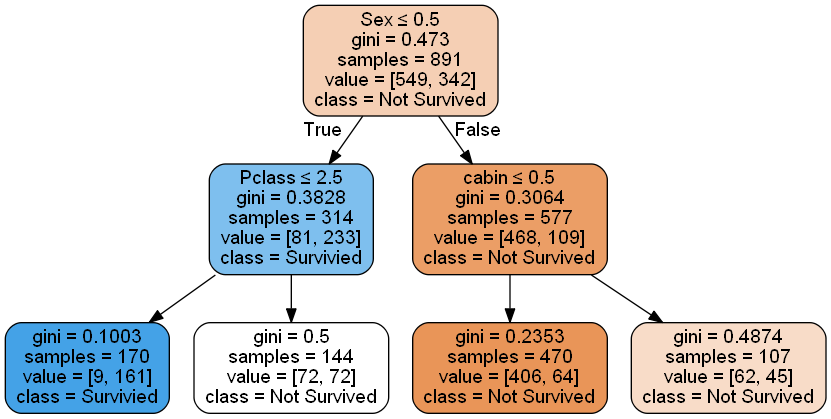

In [12]:
param_grid = [ {'max_depth':[2]} ]
Image(printTreeNode(fitTree(X,y,param_grid=param_grid), 
    feature_names=['Pclass','Sex', 'title', 'familySize', 'Fare', 'Age', 'cabin', 'Embarked'], 
    class_names=['Not Survived', 'Survivied']))

- We see that Sex is dominating feature, and PClass follows next.
- Title is 0% as we expect the variable would highly depend on 'Sex', 'Age', and 'Family Size'.

## Learning curve

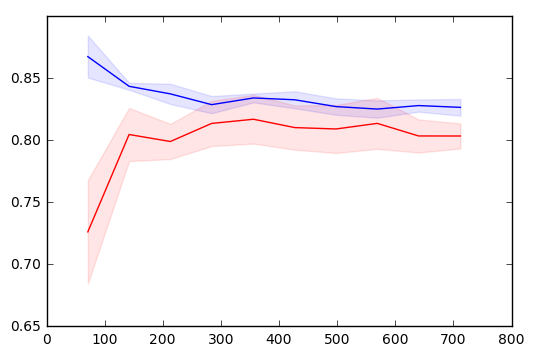

In [13]:
drawLearningCurve(clf_dt_gs, X, y)

- We see that 'Sex' feature always has greatest impact. A decision tree might suffer from local minimum in optimization by always dividing 1st node by Sex (failure of the greedy algorithm). 

- To avoid this issue, we try a random forest classifier which resolve this issue by 'random feature selection at each step' and 'bootstrapping and voting'.  

## Other metrics

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [16]:
clf_dt_gs.fit(X_train, y_train)
y_pred = clf_dt_gs.predict(X_test)

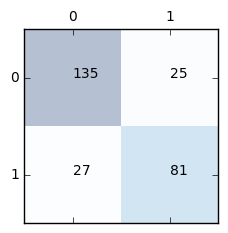

In [17]:
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(x=i,y=j,s=mat[i,j])
plt.show()

In [18]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.83      0.84       162
          1       0.75      0.76      0.76       106

avg / total       0.81      0.81      0.81       268



- We see that the current classifier is having more difficulty in predicting 'survived' than 'not survivied'.

# 6. Advanced Models

## Random Forest

In [19]:
param_grid = [ {'n_estimators':[10, 20], 
                'max_depth':[3,5], 
                'max_features':[3,5]} ]

clf_rf_gs = fitTree(X,y, estimator=RandomForestClassifier, param_grid=param_grid)
clf_rf_gs

best param: {'max_depth': 3, 'n_estimators': 20, 'max_features': 5}
grid search time: 1.08 sec.
train mean accuracy: 80.10 % (std=1.73 %)
test mean accuracy: 82.47 % (std=2.45 %)

 feature importance:
 1. Sex             45.74 %
 2. title           18.26 %
 3. Pclass          10.56 %
 4. Fare            8.88 %
 5. familySize      6.07 %
 6. cabin           5.24 %
 7. Age             4.36 %
 8. Embarked        0.89 %

 total time: 1.41 sec.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

- We don't see a noticeable improvement here. 
- Even though we still see 'Sex' is the most important feature, we see that other variables like title come into play.

## Boosting Tree. 

In [20]:
param_grid = [ {'n_estimators':[50, 100], 
                'learning_rate':[0.01,0.1],
                'max_depth':[3,5,7],
                'max_features':[3,5,None]} ]

clf_gb_gs = fitTree(X,y, estimator=GradientBoostingClassifier, param_grid=param_grid)
clf_gb_gs

best param: {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3, 'max_features': None}
grid search time: 20.86 sec.
train mean accuracy: 84.43 % (std=1.72 %)
test mean accuracy: 76.81 % (std=10.54 %)

 feature importance:
 1. Fare            33.34 %
 2. Sex             23.37 %
 3. Age             17.18 %
 4. familySize      11.19 %
 5. Pclass          6.44 %
 6. Embarked        3.51 %
 7. cabin           2.83 %
 8. title           2.15 %

 total time: 21.30 sec.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

## Neural Network (Multilayer Perception)

For the last advanced model, we apply a neural network using keras with only 1 hidden layer of 5 nodes. We also apply a regularization by adding a dropout layer. 

In [21]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import time

def fitNN(X,y):
    t1 = time.time()
    
    X_ohe = OneHotEncoder(categorical_features=[0,2,7]).fit_transform(X).toarray()
    y_ohe = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()    
        
    model = Sequential()
    model.add(Dense(10, input_dim=X_ohe.shape[1], init='uniform', activation='sigmoid'))
    model.add(Dense(5, init='uniform', activation='sigmoid')) 
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
    
    skf = StratifiedKFold(n_splits=5)
    train_scores = []
    test_scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X_ohe[train_index], X_ohe[test_index]
        y_train, y_test = y_ohe[train_index], y_ohe[test_index]

        model.fit(X_train, y_train, nb_epoch=10, batch_size=1, verbose=0)
        _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)
    
    print('train mean accuracy: %.2f %% (std=%.2f %%)' %(np.mean(train_scores)*100, np.std(train_scores)*100))
    print('test mean accuracy: %.2f %% (std=%.2f %%)' %(np.mean(test_scores)*100, np.std(test_scores)*100))
    
    print('\n total time: %.2f sec.' %(time.time()-t1))
    return model

Using TensorFlow backend.


In [22]:
model = fitNN(X,y)

train mean accuracy: 80.56 % (std=0.70 %)
test mean accuracy: 79.59 % (std=4.09 %)

 total time: 46.71 sec.


- We still see no significant improvement compared to tree-based classifiers. 